# A refactoring exercise

Let's pause for a moment and think about what we've done.
We've built a diffusion model that can generate 2D spiral data.

There are still many questions that we haven't answered:

- How does the architecture matter?
- How does the model size matter (number of parameters), within the same class of arch?
- How does the number of timesteps matter?

To answer these questions, we need to do experiments that require numerous code changes. However, the notebook is quite long even for this simple task. Let's refactor it
to make it more modular and easier to understand.

### The refactoring

There are two types of code in the notebook. The first type is stable and can be reused for other tasks. The second type is experimental and specific to the task of this notebook.

#### Stable (library) code

1. Main components of the diffusion model training pipeline:
    - Data and model setup:
        - DataLoader setup (`load_data`)
        - Model architectures (`Model1`, `Model2`, `Model3`)
        - The training loop (`train`)
    - Diffusion specific components:
        - Forward diffusion (`forward_diffusion`)
        - Denoising step (`denoising_step`)
        - Noise schedule creation (`create_noise_schedule`)
        - Sample generation (`generate_samples_by_denoising`)
2. Evaluation and visualization tools:
    - Chamfer distance calculation (`chamfer_distance`)
    - Visualization utilities (`TrajectorySet` class)

#### Experimental code

- Custom and flexible visualization of intermediate results
- Hyperparameter choices and training configurations

### File structure

The refactored code can be organized into the following files:

```
lib_1_1/
    config.py
    data.py
    model.py
    diffusion.py
    eval.py
    training_loop.py
    visualization.py
```




After refactoring, we will test that the training still works, with a much smaller notebook with less code. The following sections will produce the same results as the [original notebook](1_1_Diffusion 2D Toy.ipynb). Feel free to skim through the results.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from lib_1_1 import config, model, diffusion, data, eval, visualization
from lib_1_1.training_loop import train


device = "cuda"
training_config = config.TrainingConfig()
train_dataloader, val_dataloader = data.load_data(training_config)
model1 = model.Model1(
    hidden_features=[512, 256, 256],
    num_timesteps=training_config.num_denoising_steps
).to(device)
model2 = model.Model2(
    hidden_features=[512, 256, 256],
    num_timesteps=training_config.num_denoising_steps
).to(device)
model3 = model.Model3(
    hidden_features=[128, 128, 128],
    num_timesteps=training_config.num_denoising_steps
).to(device)
print(f"model1 size: {sum(p.numel() for p in model1.parameters())}")
print(f"model2 size: {sum(p.numel() for p in model2.parameters())}")
print(f"model3 size: {sum(p.numel() for p in model3.parameters())}")



model1 size: 199682
model2 size: 215554
model3 size: 182410


Run a quick training as a sanity check:

In [3]:
import torch

noise_schedule = diffusion.create_noise_schedule(n_T=training_config.num_denoising_steps, device=device)
optimizer3 = torch.optim.Adam(model3.parameters(), lr=training_config.learning_rate)
train(
    model3, train_dataloader, noise_schedule, optimizer3, steps=10,
    device=device, num_denoising_steps=training_config.num_denoising_steps
)


Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 10


tensor(1.0369, device='cuda:0', grad_fn=<MseLossBackward0>)

### Visualize forward diffusion

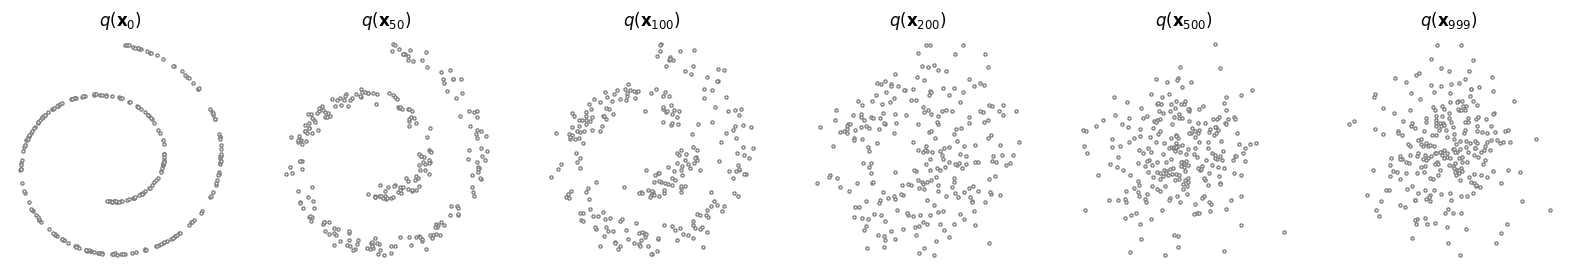

In [4]:
import matplotlib.pyplot as plt
from lib_1_1.diffusion import forward_diffusion

x_0 = next(iter(val_dataloader))
x_0 = x_0.to(device)
x_t_list = []
common_noise = torch.randn_like(x_0)

fig, axs = plt.subplots(1, 6, figsize=(20, 3))
for i, t in enumerate([0, 50, 100, 200, 500, 999]):
    t_ = torch.full((x_0.shape[0],), t, device=device)
    x_t = forward_diffusion(x_0, t_, noise_schedule, noise=common_noise)[0]
    x_t = x_t.cpu()
    axs[i].scatter(x_t[:,0], x_t[:,1], color='white', edgecolor='gray', s=5)
    axs[i].set_axis_off()
    axs[i].set_title('$q(\mathbf{x}_{'+str(t)+'})$')

### Visualize forward diffusion trajectories

Let's plot the trajectories of the forward diffusion process. For each data point $\mathbf{x}_0$, we plot the sequence:

$$ \mathbf{x}_0, \mathbf{x}_{10}, \mathbf{x}_{20}, \ldots, \mathbf{x}_{990} $$

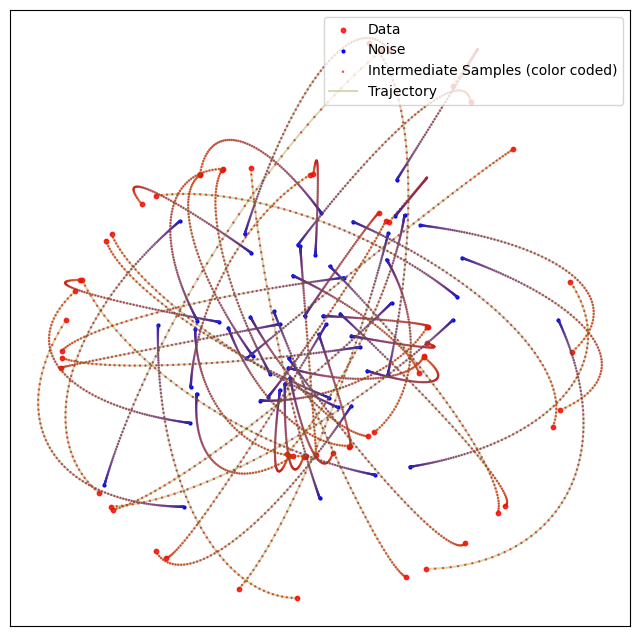

<Figure size 640x480 with 0 Axes>

In [5]:
# Generate forward diffusion trajectories (would they look like straight lines or curves?)
from lib_1_1.visualization import TrajectorySet

x_clean = next(iter(val_dataloader))
x_clean = x_clean.to(device)

# Run forward diffusion
x_t_list = []
torch.manual_seed(0)
common_noise = torch.randn_like(x_clean)

for t in range(0, 1000, 10):
    t_ = torch.full((x_clean.shape[0],), t, device=device)
    x_t = forward_diffusion(x_clean, t_, noise_schedule, noise=common_noise)[0]
    x_t_list.append(x_t)

traj = torch.stack(x_t_list).cpu().numpy()
traj_set = TrajectorySet(traj)
_ = traj_set.plot_trajectories(n=60, show_figure=True, figsize=(8, 8))

### Visualize denoising trajectories

  0%|          | 0/1000 [00:00<?, ?it/s, std=1.95]

100%|██████████| 1000/1000 [00:01<00:00, 569.47it/s, std=233]


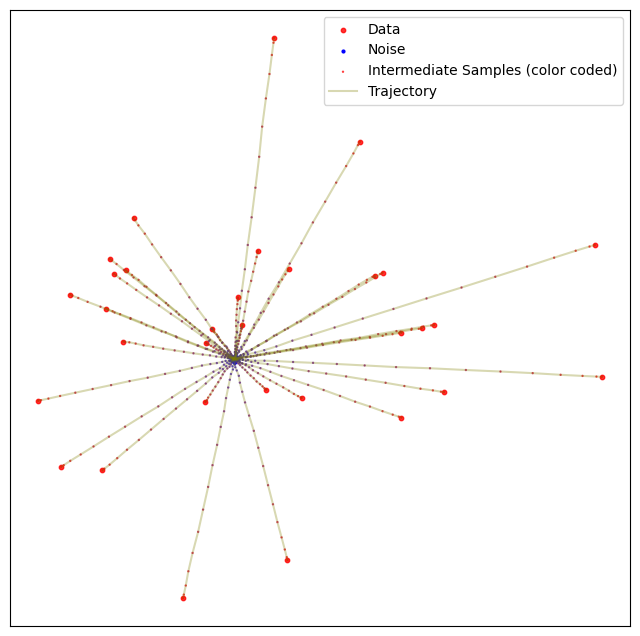

<Figure size 640x480 with 0 Axes>

In [6]:
from lib_1_1.visualization import visualize_denoising_model

visualize_denoising_model(
    model3,
    noise_schedule,
    num_samples=32,
    timestep_size=50,
    num_denoising_steps=training_config.num_denoising_steps,
    device=device
)


In [7]:
train(
    model3, train_dataloader, noise_schedule, optimizer3, steps=1000,
    device=device, num_denoising_steps=training_config.num_denoising_steps
)

Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 1000


tensor(0.3241, device='cuda:0', grad_fn=<MseLossBackward0>)

  0%|          | 0/1000 [00:00<?, ?it/s, std=1.06] 

100%|██████████| 1000/1000 [00:01<00:00, 570.73it/s, std=2.14]


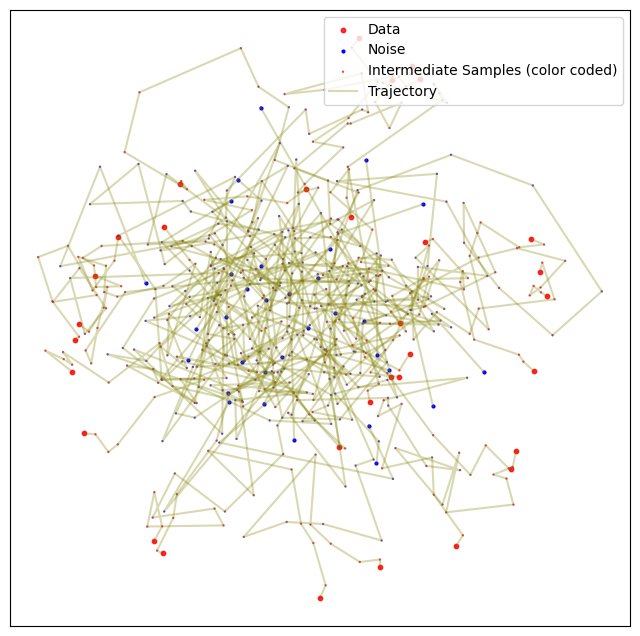

<Figure size 640x480 with 0 Axes>

In [8]:
visualize_denoising_model(
    model3,
    noise_schedule,
    num_samples=32,
    timestep_size=50,
    num_denoising_steps=training_config.num_denoising_steps,
    device=device
)

  0%|          | 0/1000 [00:00<?, ?it/s, std=0.951]

100%|██████████| 1000/1000 [00:01<00:00, 572.56it/s, std=2.13]


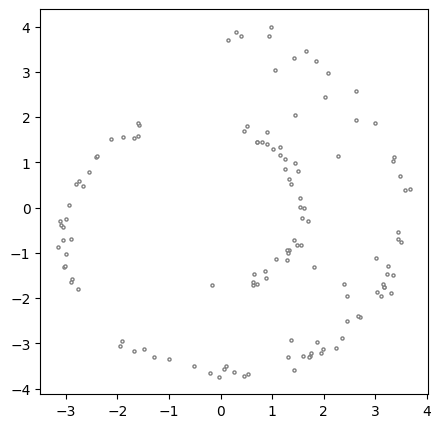

In [9]:
from lib_1_1.visualization import visualize_sampled_data

visualize_sampled_data(model3, noise_schedule, num_samples=128, device=device)

## Animate the learning process

In [18]:
from lib_1_1.diffusion import generate_samples_by_denoising
from tqdm import tqdm

model3 = model.Model3(
    hidden_features=[128, 128, 256],
    num_timesteps=training_config.num_denoising_steps,
).to(device)
model3_optimizer = torch.optim.Adam(model3.parameters(), lr=training_config.learning_rate)
# model3_optimizer = torch.optim.AdamW(model3.parameters(), lr=training_config.learning_rate, weight_decay=training_config.weight_decay)

samples = []
steps_to_checkpoint = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]
all_trajs = []

pbar = tqdm(range(len(steps_to_checkpoint)))
for i in pbar:
    if i > 0:
        steps_to_train = steps_to_checkpoint[i] - steps_to_checkpoint[i-1]
    else:
        steps_to_train = i
    model3_loss = train(
        model3, train_dataloader,
        noise_schedule, model3_optimizer,
        steps=steps_to_train, silent=True,
        device=device, num_denoising_steps=training_config.num_denoising_steps
    )
    if i > 0:
        pbar.set_description(f"loss: {model3_loss:.4f}")
    torch.manual_seed(0)
    traj = generate_samples_by_denoising(
        model3, torch.randn(128, 2), noise_schedule, n_T=1000, device=device, return_full_trajectory=True, silent=True)
    traj = traj.detach().cpu().numpy()
    samples.append(traj[0])
    traj = traj[::20, :, :]
    traj_set = TrajectorySet(traj)
    all_trajs.append(traj_set)

  0%|          | 0/10 [00:00<?, ?it/s]

loss: 0.2669: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]


  0%|          | 0/1000 [00:00<?, ?it/s, std=0.933]

100%|██████████| 1000/1000 [00:01<00:00, 571.12it/s, std=2.01]


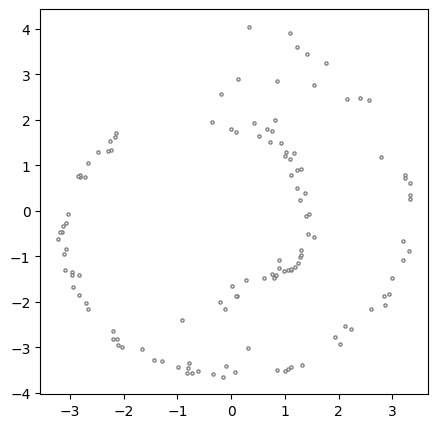

In [19]:
visualize_sampled_data(model3, noise_schedule, num_samples=128, device=device)

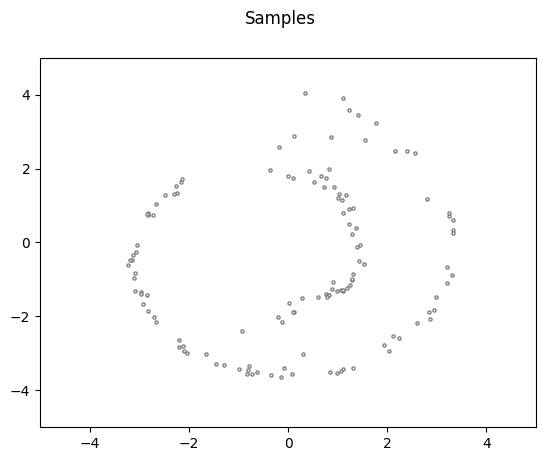

In [20]:
import matplotlib.animation as animation
from IPython.display import HTML

fig, ax = plt.subplots()
sc = ax.scatter(samples[i][:, 0], samples[i][:, 1], color='white', edgecolor='gray', s=5)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
fig.suptitle("Samples")

def update(i):
    sc.set_offsets(samples[i])
    return sc,

ani = animation.FuncAnimation(fig, update, frames=range(len(steps_to_checkpoint)), interval=1000, blit=True, repeat=False)
HTML(ani.to_jshtml())

In [23]:
# A shared state to store the frames for the vector field animation.
_state = {
    "frames": {},
}

from ipywidgets import interact

def show_traj_at_learning_step(i=0):
    train_steps = steps_to_checkpoint[i]
    bytes_value = all_trajs[i].plot_trajectories(
        n=12, show_figure=True, figsize=(6, 6),
        with_ticks=True, title=f"train steps = {train_steps}",
        xlim=(-5, 5), ylim=(-5, 7),
        with_lines=True,
    )
    _state["frames"][train_steps] = bytes_value

interact(show_traj_at_learning_step, i=(0, len(all_trajs)-1, 1))

interactive(children=(IntSlider(value=0, description='i', max=9), Output()), _dom_classes=('widget-interact',)…

<function __main__.show_traj_at_learning_step(i=0)>

## Compare model performance

In [27]:
model1 = model.Model1(
    hidden_features=[512, 256, 256],
    num_timesteps=training_config.num_denoising_steps
).to(device)
model1_optimizer = torch.optim.Adam(model1.parameters(), lr=training_config.learning_rate)
model1_loss = train(model1, train_dataloader, noise_schedule, model1_optimizer, steps=5000, device=device, num_denoising_steps=training_config.num_denoising_steps)

model2 = model.Model2(
    hidden_features=[512, 256, 256],
    num_timesteps=training_config.num_denoising_steps
).to(device)
model2_optimizer = torch.optim.Adam(model2.parameters(), lr=training_config.learning_rate)
model2_loss = train(model2, train_dataloader, noise_schedule, model2_optimizer, steps=5000, device=device, num_denoising_steps=training_config.num_denoising_steps)

model3 = model.Model3(
    hidden_features=[128, 128, 128],
    num_timesteps=training_config.num_denoising_steps
).to(device)
model3_optimizer = torch.optim.Adam(model3.parameters(), lr=training_config.learning_rate)
model3_loss = train(model3, train_dataloader, noise_schedule, model3_optimizer, steps=5000, device=device, num_denoising_steps=training_config.num_denoising_steps)


Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000
Training on device: cuda


  0%|          | 0/3125 [00:00<?, ?it/s]

Reached the max training steps: 5000


  0%|          | 0/1000 [00:00<?, ?it/s, std=1.49]

100%|██████████| 1000/1000 [00:00<00:00, 1016.28it/s, std=62.6]


Model 1 Size: 199682 Chamfer Distance: 1.546387922825363


100%|██████████| 1000/1000 [00:01<00:00, 970.83it/s, std=1.93]


Model 2 Size: 215554 Chamfer Distance: 0.37767705435093313


100%|██████████| 1000/1000 [00:01<00:00, 556.81it/s, std=2.01]


Model 3 Size: 182410 Chamfer Distance: 0.2109826764526811


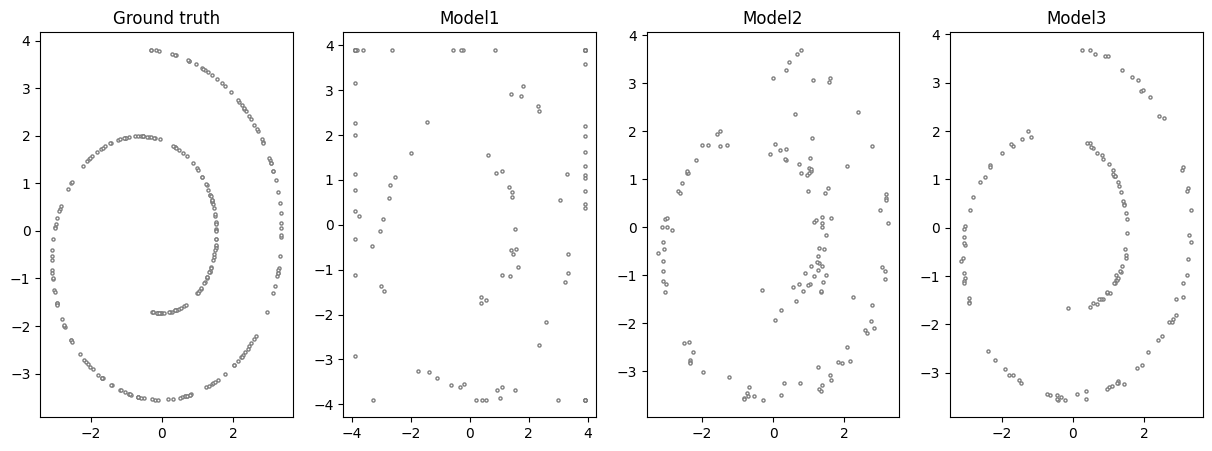

In [28]:
import torch
import numpy as np
from lib_1_1.eval import chamfer_distance


# The target spiral points for comparison
target_spiral = next(iter(train_dataloader))

generated_points_1 = generate_samples_by_denoising(model1, torch.randn(128, 2), noise_schedule, n_T=1000, device=device)
generated_points_1 = np.clip(generated_points_1.cpu().numpy(), -3.9, 3.9)
chamfer_dist = chamfer_distance(generated_points_1, target_spiral, direction='bi')
print("Model 1 Size:", sum(p.numel() for p in model1.parameters()), "Chamfer Distance:", chamfer_dist)

generated_points_2 = generate_samples_by_denoising(model2, torch.randn(128, 2), noise_schedule, n_T=1000, device=device)
generated_points_2 = generated_points_2.cpu().numpy()
chamfer_dist = chamfer_distance(generated_points_2, target_spiral, direction='bi')
print("Model 2 Size:", sum(p.numel() for p in model2.parameters()), "Chamfer Distance:", chamfer_dist)

generated_points_3 = generate_samples_by_denoising(model3, torch.randn(128, 2), noise_schedule, n_T=1000, device=device)
generated_points_3 = generated_points_3.cpu().numpy()
chamfer_dist = chamfer_distance(generated_points_3, target_spiral, direction='bi')
print("Model 3 Size:", sum(p.numel() for p in model3.parameters()), "Chamfer Distance:", chamfer_dist)

# # visualize the sampled images side by side
def visualize_sampled_data_side_by_side(models, generated_points):
    fig, axs = plt.subplots(1, len(models) + 1, figsize=(5 * len(models), 5))
    # Add ground truth
    axs[0].scatter(target_spiral[:, 0], target_spiral[:, 1], color='white', edgecolor='gray', s=5)
    axs[0].set_title("Ground truth")

    for i, (model, points) in enumerate(zip(models, generated_points)):
        axs[i+1].scatter(points[:,0], points[:,1], color='white', edgecolor='gray', s=5)
        axs[i+1].set_title(model.__class__.__name__)

visualize_sampled_data_side_by_side([model1, model2, model3], [generated_points_1, generated_points_2, generated_points_3])

## Conclusion

With refactoring, we were able to replicate the functionality of the original notebook,
while making it much shorter and easier to understand.

Next, we are ready to do a series of experiments to understand the impact of hyperparameters
in the training algorithm.
